In [1]:
# Put all imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '../data/uiuc-gpa-dataset.csv'
df = pd.read_csv(file_path)

In [3]:
debug_df = df.sample(n=100)  # Smaller sample for debugging
working_df = df

In [4]:
debug_df.to_pickle('debug_dataset.pkl')
working_df.to_pickle('working_dataset.pkl')

# Checking for Missing Values

The first thing this will print is df.isnull(), which gives us a high level insight as to what data is there. We can see most of them have 69069 entries, with the exception of sched type and primary instructor, which will be considered as missing features.


In [5]:
# Check for any missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Year                      0
Term                      0
YearTerm                  0
Subject                   0
Number                    0
Course Title              0
Sched Type            10053
A+                        0
A                         0
A-                        0
B+                        0
B                         0
B-                        0
C+                        0
C                         0
C-                        0
D+                        0
D                         0
D-                        0
F                         0
W                         0
Primary Instructor      177
dtype: int64


# Overall Distribution

This will show us the overall grade distribution across all courses. As this is for all courses, it is more to help us become familiar with the data; we notice a high amount of A's which is a potential bias in the labels.

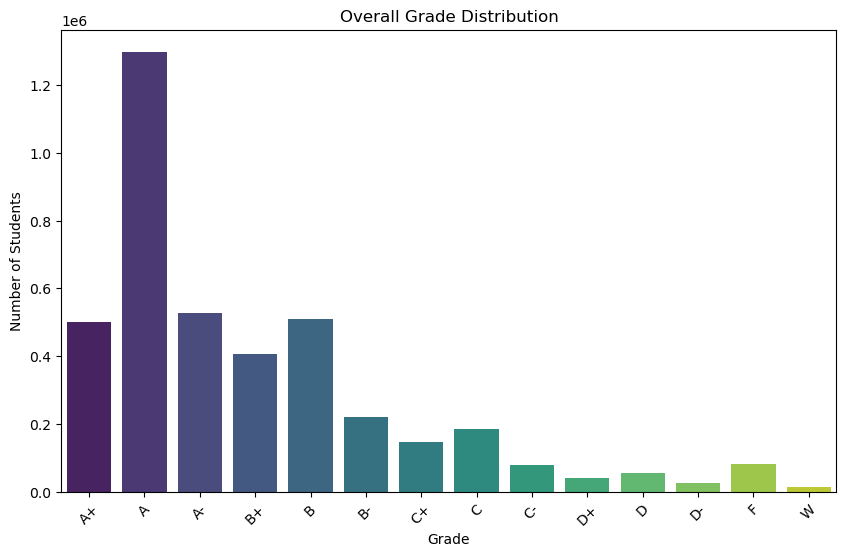

In [6]:
grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']
grade_summary = df[grade_columns].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=grade_summary.index, y=grade_summary.values, palette='viridis')
plt.title('Overall Grade Distribution')
plt.xlabel('Grade')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.show()

# Grades Grouped By Instructor

Here, we can see that there is some bias with regard to the instructor. For example, Professor Holden seems to give more A+ than any other grade, whereas Professor Washington does not seem to give any A+ in this data. Thus, it can be seen that the instructor is an important factor to consider in the model.

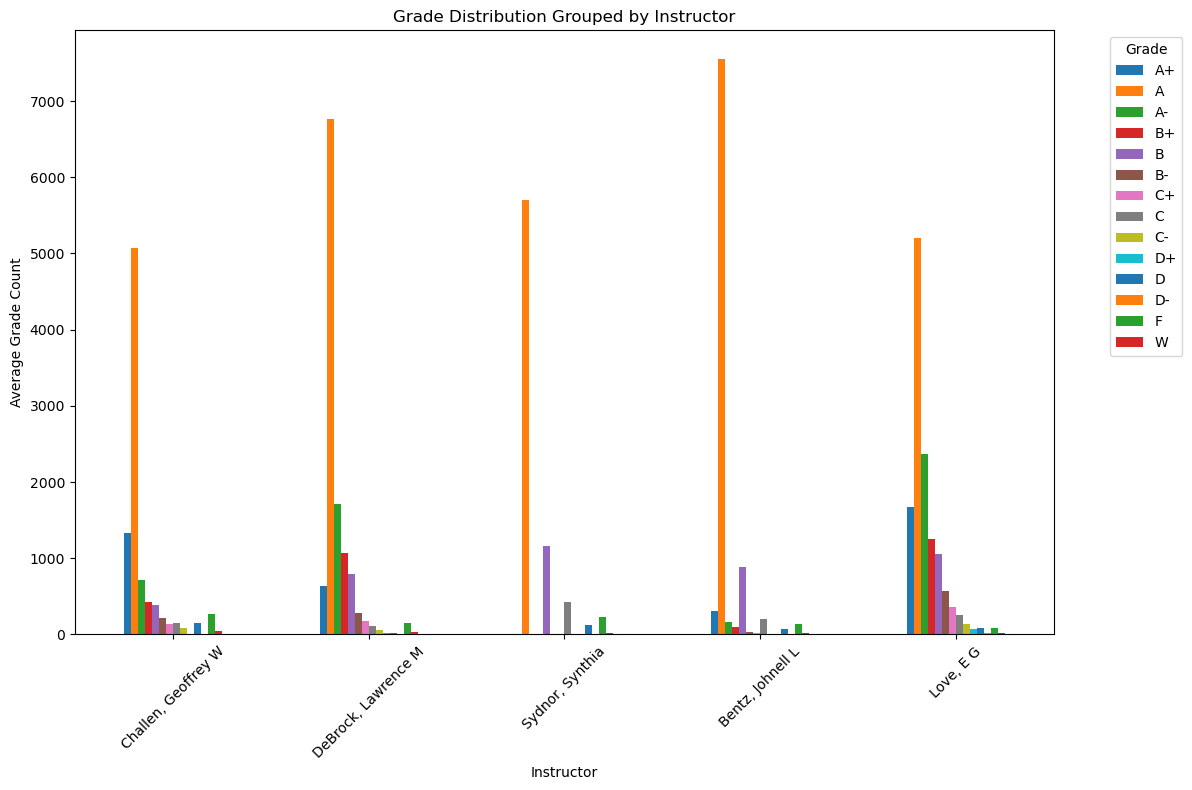

In [10]:
instructor_grades = df.groupby('Primary Instructor')[grade_columns].sum().sort_values(by='A', ascending=False).head(10)

# Sample a few instructors for visualization
sample_instructors = instructor_grades.sample(5, random_state=42)

# Plot grouped by instructor instead of grade
sample_instructors.plot(kind='bar', figsize=(12, 8))
plt.title('Grade Distribution Grouped by Instructor')
plt.xlabel('Instructor')
plt.ylabel('Average Grade Count')
plt.xticks(rotation=45)
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Grade Distribution by Subject

Here, we will learn about the grade distribution across different subjects. The X axis of the plot represents the subject, and the color value at grade value represents how often that grade was achieved for that subject. For example, it seems BADM courses have a high percentage of A's. STAT, while it also has more A's than anything else, is a relatively more even distribution. Thus, the course subject is a very relevant piece of information.

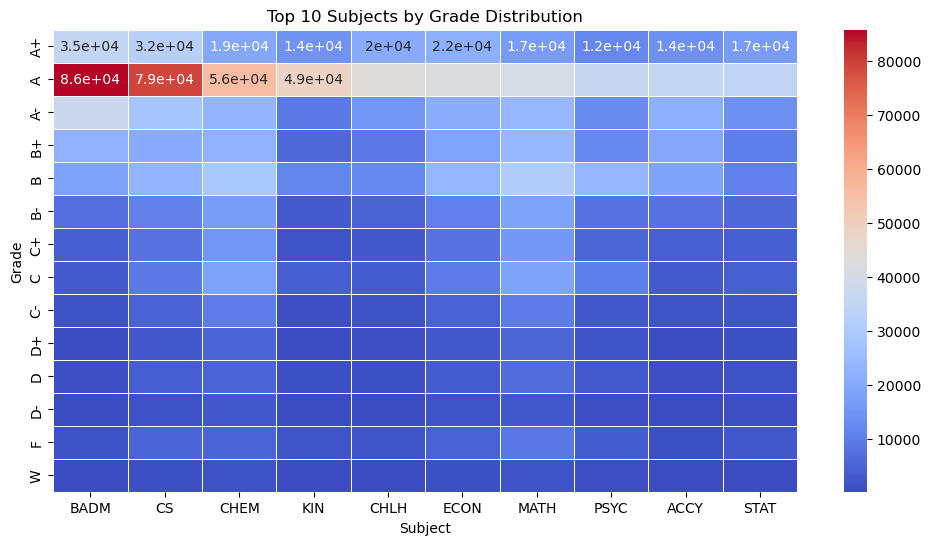

In [11]:
# Analyze grade distribution by subject
subject_grades = df.groupby('Subject')[grade_columns].sum().sort_values(by='A', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.heatmap(subject_grades.T, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Top 10 Subjects by Grade Distribution')
plt.xlabel('Subject')
plt.ylabel('Grade')
plt.show()

# Distribution by Year

It seems unlikely that the year would affect grades too much, but we might get a good idea of trends of grade inflation based on some data.

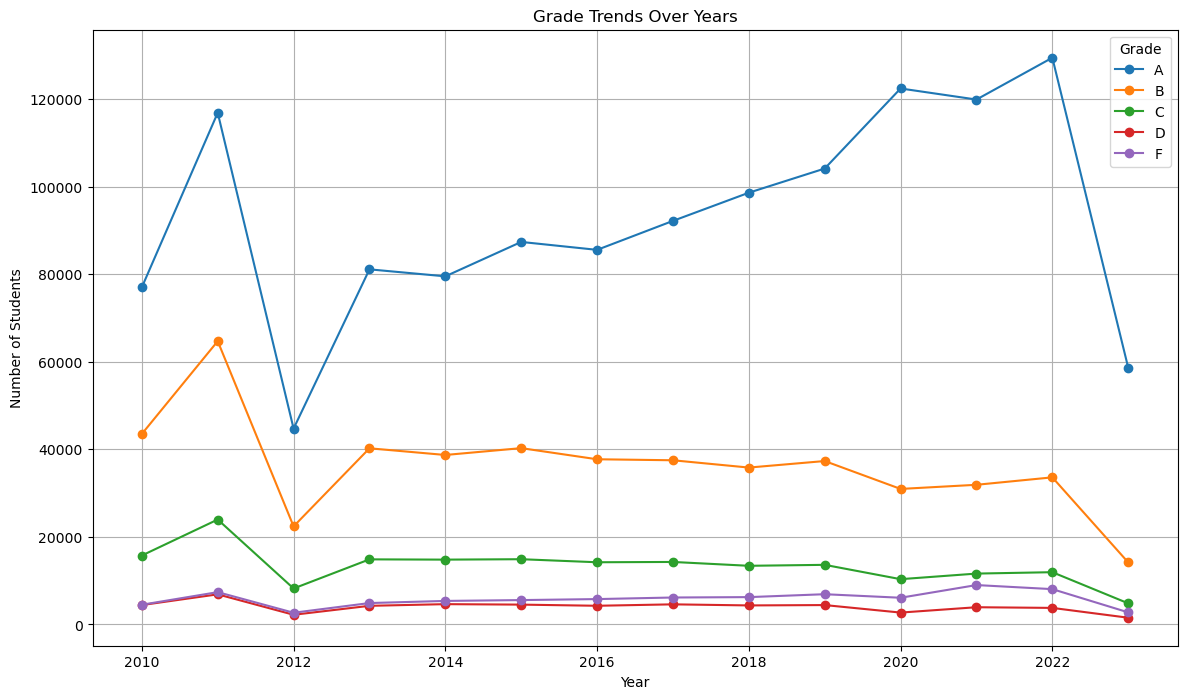

In [12]:
yearly_grades = df.groupby('Year')[grade_columns].sum()

plt.figure(figsize=(14, 8))
for grade in ['A', 'B', 'C', 'D', 'F']:
    plt.plot(yearly_grades.index, yearly_grades[grade], marker='o', label=grade)

plt.title('Grade Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Students')
plt.legend(title='Grade')
plt.grid()
plt.show()


# Distribution by Course Level

It seems like a good idea to know the course level, too. As we can see, the distribution across course level is very different. A few observations are that there are fewer A's as the course level increases, but seemingly more B and B+. However, some of the trends are inconsistent. The number of B's tends to increase, but decreases again for 700 level courses. C's similarly seem to stay consistent, almost vanish for 500 level courses, reach their maximum percentage for 600 level courses, then decrease again for 700.

<Figure size 1200x600 with 0 Axes>

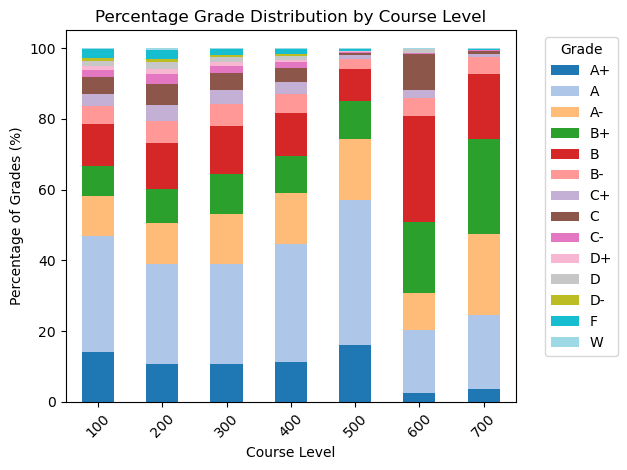

In [13]:
# Calculate the total number of grades per course level
df['Course Level'] = df['Number'].astype(str).str[0] + '00'

level_grades = df.groupby('Course Level')[grade_columns].sum()

# Convert the grade counts to percentages for each course level
level_grades_percentage = level_grades.div(level_grades.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
plt.figure(figsize=(12, 6))
level_grades_percentage.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Percentage Grade Distribution by Course Level')
plt.xlabel('Course Level')
plt.ylabel('Percentage of Grades (%)')
plt.xticks(rotation=45)
plt.legend(title='Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Cross Correlation of Grades

This graph shows us an interesting insight. The warmer values on the heatmap are concentrated around the diagonal. This shows us that, for a given class, if there are many B's, a new sample is likely to be around a B (the correlation between B and B+ is much lower than a correlation between a B and an A+). So if the mean grade is an A for a given class, we should weigh those percentages and lower the likelihood of getting an F, but keep the likelihood of A+ and A- very high.

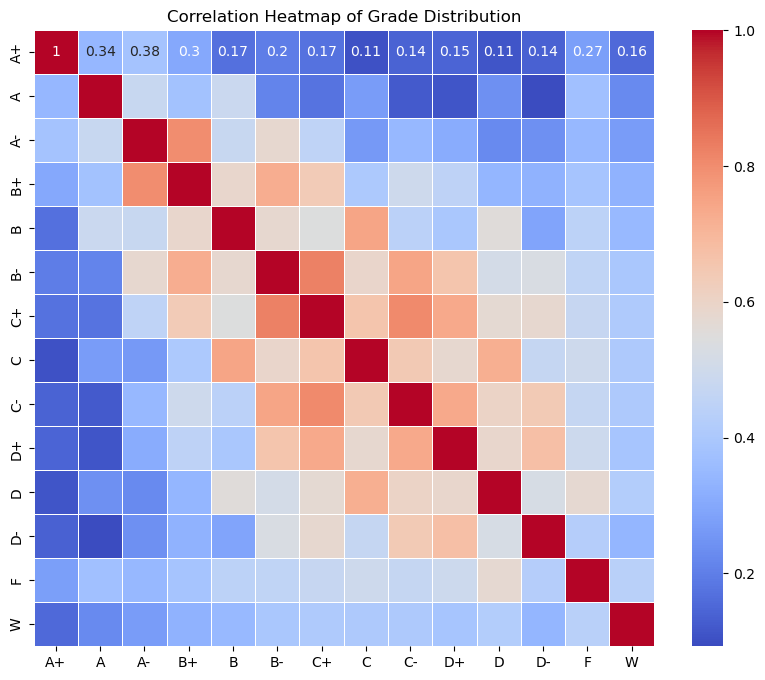

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[grade_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Grade Distribution')
plt.show()

# **Data Problems Analysis**

## In this dataset, we encountered multiple challenges with our dataset that could impact ultimately impact our analysis and modeling:

- **Missing Data:** Columns like “Sched Type” and “Primary Instructor” contain missing values, which may bias or misrepresent trends that we find and could lead to an incomplete analysis. Some solutions could include removing rows with missing values or computing them based on similar data points.
- **Sparse Data:** Certain grade categories, particularly those at the extremes (like A+ and F), have low counts, leading to sparse data. Sparse data can interfere with reliable statistical analysis or model accuracy, since lower-frequency categories are underrepresented. To address this, we could consider aggregating similar categories or applying other smoothing techniques.
- **Imbalanced Data:** The grade distribution analysis reveals a higher frequency of A grades, indicating an imbalance. This bias may affect interpretations, making it appear as if the overall student performance is skewed toward higher grades. However, this skew may be an important characteristic of the data that our model should capture, as it reflects real trends in student performance. Therefore, we may choose to retain this aspect of the data instead of removing it entirely.
